Question 01

166.96998055561335
9.814100637401074


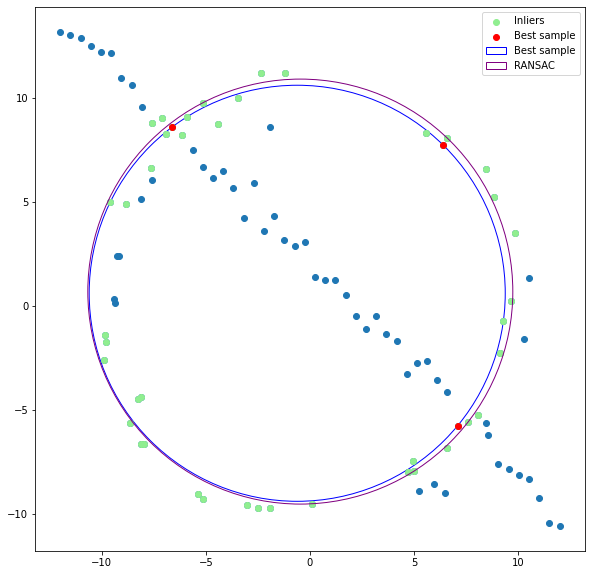

In [13]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import linalg

def ShortestDistance(p,centerx,centery,radius):
    d= np.array(abs(((p[:,0]-centerx)**2+(p[:,1]-centery)**2)**0.5-radius))
    return d

def Circlefinder(pt1, pt2, pt3):
    temp = pt2[0]**2 + pt2[1]**2
    bc = (pt1[0]**2 + pt1[1]**2 - temp)/2
    cd = (temp - pt3[0]**2 - pt3[1]**2)/2
    det = (pt1[0] - pt2[0]) * (pt2[1] - pt3[1]) - (pt2[0] - pt3[0]) * (pt1[1] - pt2[1])
    if abs(det) < 1.0e-10:
        return None
    cx = (bc*(pt2[1] - pt3[1]) - cd*(pt1[1] - pt2[1]))/ det
    cy = ((pt1[0] - pt2[0]) * cd - (pt2[0] - pt3[0])*bc)/ det
    r = ((cx - pt1[0])**2 + (cy - pt1[1])**2)**0.5

    return cx, cy, r

def CirclePlotting(Data,Datalist,color='r'):
    cen_x, cen_y, radius = Circlefinder(Datalist[Data[0]],Datalist[Data[1]],Datalist[Data[2]])
    c = plt.Circle((cen_x, cen_y), radius, fill=False)
    c.set_color(color)
    return c

def RANSAC(Data,iteration,thresh,NoOfInlier):
    maximum = 0
    output = np.array([])
    for i in range(iteration):
        randomPoints = np.random.choice(Data.size//2, size=3, replace=False)
        cen_x, cen_y, radius = Circlefinder(Data[randomPoints[0]],Data[randomPoints[1]],Data[randomPoints[2]])
        PO = ShortestDistance(Data, cen_x, cen_y, radius)

        if radius > max(Data[:,1])*1.5:
            continue
        inliers = Data[PO < thresh]

        if len(inliers) > NoOfInlier:
               
            shrt_d = ShortestDistance (inliers,cen_x,cen_y,radius)
            mean = sum(shrt_d/shrt_d.size)
            if maximum < len(inliers):
                best = mean
                output = randomPoints
                inli = inliers
            elif maximum == len(inliers) and best > mean:
                best = mean
                output = randomPoints
                inli = inliers
    print(radius)
    return output,inli

# np . random. seed ( 0 )
N = 100
half_n = N//2
r = 10
s = r /16
t = np . random. uniform(0 , 2*np . pi , half_n )
n = s*np . random. randn ( half_n )
x , y = ( r + n)*np . cos ( t ) , ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x . reshape ( half_n , 1 ) , y.reshape ( half_n , 1 ) ) )
m, b = -1, 2
x = np.linspace (-12, 12 , half_n )
y = m*x + b + s*np.random.randn(half_n)
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y.reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) )

ranL, bestInlier = RANSAC(X,500,1,40)         
circ1 = CirclePlotting(ranL,X, color = 'blue')
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect(1)
ax.add_artist(circ1)
p1 = ax.scatter(X[:,0],X[:,1])
Inliers = ax.scatter(bestInlier[:,0],bestInlier[:,1], color='lightgreen' )
bestfit, inl = RANSAC(bestInlier,50,1,bestInlier.size//2.2)
circ2 = CirclePlotting(bestfit,bestInlier, color ='purple')
ax.add_artist( circ2 )
Y = np.vstack((X[ranL[0]],X[ranL[1]],X[ranL[2]]))
Bestsamples = ax.scatter(Y[:,0],Y[:,1], c = 'r')
plt.legend(handles=[Inliers,Bestsamples,circ1,circ2],labels=['Inliers','Best sample','Best sample','RANSAC'])
plt.show()


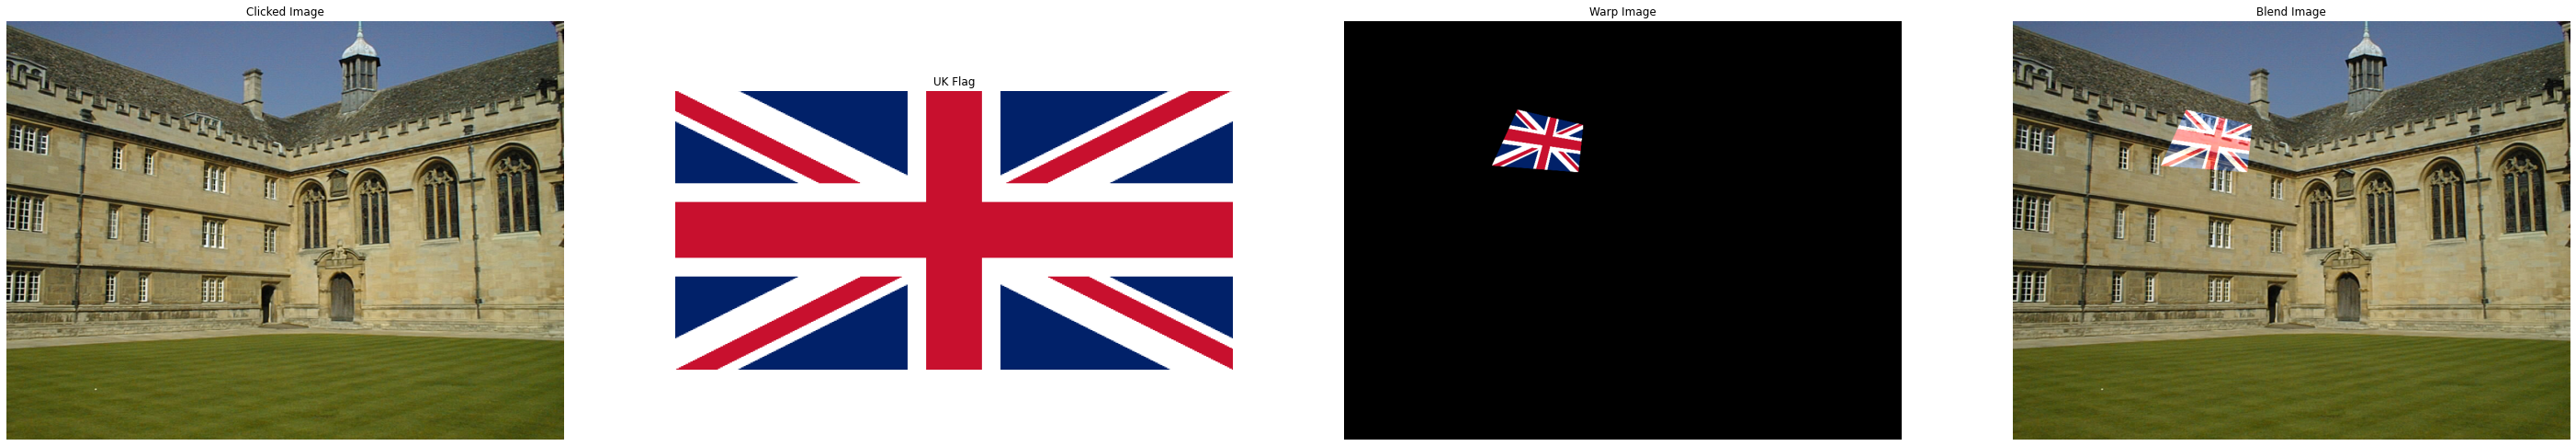

In [30]:
count = 0
points = []
width = 0
height = 0

arch_img1 = cv.imread(r'./assingment2_images/001.jpg', cv.IMREAD_COLOR)
arch_img2 = cv.imread(r'./assingment2_images/003.jpg', cv.IMREAD_COLOR)
imgflag = cv.imread(r'./assingment2_images/Flag_of_the_United_Kingdom.svg.png', cv.IMREAD_REDUCED_COLOR_4)
img1 = arch_img1
img2 = arch_img2
def mousePoints(event, x, y, flags, params):
    global count
    global points
    if count < 4:
        if event == cv.EVENT_LBUTTONDOWN:
            points.append((x, y))
            count += 1
    return None
def getshape(pts):
    global width
    global height
    width = (abs(pts[0][0] - pts[1][0]) + abs(pts[2][0] - pts[3][0]))//2
    height = (abs(pts[0][1] - pts[2][1]) + abs(pts[1][1] - pts[3][1]))//2
    return width, height
cv.imshow("original image", arch_img1)
cv.setMouseCallback("original image", mousePoints)
cv.waitKey(0)
cv.destroyAllWindows() 

pts_src = np.array([[0,0], [imgflag.shape[1],0], [0, imgflag.shape[0]], [imgflag.shape[1],imgflag.shape[0]]]) 
pts_dst = np.array(points)
shape0, shape1 = getshape(points)

h , status = cv.findHomography(pts_src, pts_dst,cv.RANSAC, 5.0)
output_imge = cv.warpPerspective(imgflag, h, (arch_img1.shape[1], arch_img1.shape[0]))
blend_image = cv.addWeighted(arch_img1, 0.95, output_imge, 0.8, 0.0)

fig, ax = plt.subplots(1,4, figsize = (50,10))
ax[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB)), ax[0].set_title("Clicked Image"), ax[0].axis('off') 
ax[1].imshow(cv.cvtColor(imgflag, cv.COLOR_BGR2RGB)), ax[1].set_title("UK Flag"), ax[1].axis('off') 
ax[2].imshow(cv.cvtColor(output_imge, cv.COLOR_BGR2RGB)), ax[2].set_title("Warp Image"),ax[2].axis('off')
ax[3].imshow(cv.cvtColor(blend_image, cv.COLOR_BGR2RGB)), ax[3].set_title("Blend Image"), ax[3].axis('off')
plt.show()

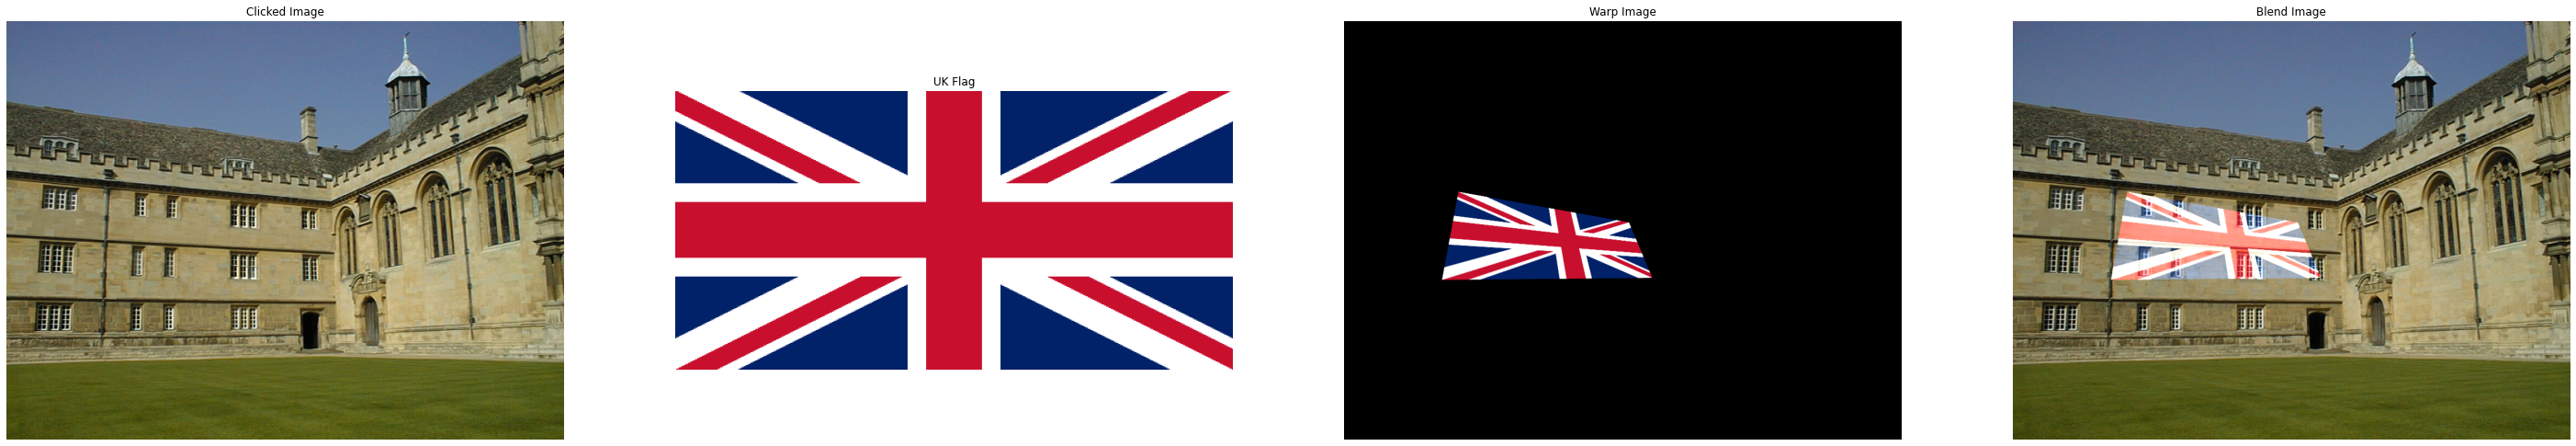

In [33]:
count = 0
points = []
width = 0
height = 0

arch_img1 = cv.imread(r'./assingment2_images/001.jpg', cv.IMREAD_COLOR)
arch_img2 = cv.imread(r'./assingment2_images/003.jpg', cv.IMREAD_COLOR)
imgflag = cv.imread(r'./assingment2_images/Flag_of_the_United_Kingdom.svg.png', cv.IMREAD_REDUCED_COLOR_4)
img1 = arch_img1
img2 = arch_img2
def mousePoints(event, x, y, flags, params):
    global count
    global points
    if count < 4:
        if event == cv.EVENT_LBUTTONDOWN:
            points.append((x, y))
            count += 1
    return None
def getshape(pts):
    global width
    global height
    width = (abs(pts[0][0] - pts[1][0]) + abs(pts[2][0] - pts[3][0]))//2
    height = (abs(pts[0][1] - pts[2][1]) + abs(pts[1][1] - pts[3][1]))//2
    return width, height
cv.imshow("original image", arch_img2)
cv.setMouseCallback("original image", mousePoints)
cv.waitKey(0)
cv.destroyAllWindows() 

pts_src = np.array([[0,0], [imgflag.shape[1],0], [0, imgflag.shape[0]], [imgflag.shape[1],imgflag.shape[0]]]) 
pts_dst = np.array(points)
shape0, shape1 = getshape(points) 

h , status = cv.findHomography(pts_src, pts_dst,cv.RANSAC, 5.0)
output_imge = cv.warpPerspective(imgflag, h, (arch_img2.shape[1], arch_img2.shape[0]))
blend_image = cv.addWeighted(arch_img2, 0.95, output_imge, 0.8, 0.0)

fig, ax = plt.subplots(1,4, figsize = (50,10))
ax[0].imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB)), ax[0].set_title("Clicked Image"), ax[0].axis('off') 
ax[1].imshow(cv.cvtColor(imgflag, cv.COLOR_BGR2RGB)), ax[1].set_title("UK Flag"), ax[1].axis('off') 
ax[2].imshow(cv.cvtColor(output_imge, cv.COLOR_BGR2RGB)), ax[2].set_title("Warp Image"),ax[2].axis('off')
ax[3].imshow(cv.cvtColor(blend_image, cv.COLOR_BGR2RGB)), ax[3].set_title("Blend Image"), ax[3].axis('off')
plt.show()